# LIF Neuron frequency response function

When a neuron receives synaptic input at a certain rate, at what rate does it spike, and how does this depend on the synaptic strength?

In [1]:
import torch
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
from bindsnet.network.topology import Connection
import bindsnet.analysis.plotting

from homeostatic_LIF_neuron import HomestaticLIFNodes
from homeostatic_STDP import HomeostaticSTDP
from bindsnet.learning import PostPre

plt.rc('figure', figsize=(12.0, 8.0))

In [2]:
input_frequency_range = torch.arange(1.,1000.,10) # Hz
input_weight_range = torch.arange(1.,25,1)
frequencies, weights = torch.meshgrid(input_frequency_range, input_weight_range)
time = 10000 # ms

In [3]:
# Want to connect input_frequency_range.numel() neurons to [input_frequency_range.numel(),input_weight_range.numel()] neurons
# Need Nf*Nf*Nw weights - each input neuron connects to a row of output neurons with input_weight_range weights
# manually construct this weight matrix
all_weights = torch.zeros(input_frequency_range.numel(),input_frequency_range.numel(),input_weight_range.numel())
for i in range(input_frequency_range.numel()):
	all_weights[i,i,:] = input_weight_range

In [4]:
network = Network()

# Create and add input, output layers.
input_layer = HomestaticLIFNodes(n=input_frequency_range.numel(), traces=True, tc_decay=10, thresh=-50, rest=-70, reset=-70, refrac=1)
test_layer = HomestaticLIFNodes(shape=(input_frequency_range.numel(),input_weight_range.numel()), traces=True, tc_decay=10, thresh=-50, rest=-70, reset=-70, refrac=1)
network.add_layer(layer=input_layer, name='input_layer')
network.add_layer(layer=test_layer, name='test_layer')

connection = Connection(
    source=input_layer,
    target=test_layer,
	update_rule = HomeostaticSTDP,
    gamma=0,
    nu=0,
    w=all_weights,
)
network.add_connection(connection=connection, source='input_layer', target='test_layer')

# Create and add monitors for spikes and voltages
input_monitor = Monitor(obj=input_layer, state_vars=('s'), time=time)
test_monitor = Monitor(obj=test_layer, state_vars=('s', 'v'), time=time)
network.add_monitor(monitor=input_monitor, name='input_monitor')
network.add_monitor(monitor=test_monitor, name='test_monitor')

# input layer spikes - Poisson
input_layer_spikes = (torch.rand(time,input_frequency_range.numel()) <= input_frequency_range/1000).bool()

# Simulate network on input data - clamp input layer to spike as we want
network.run(inputs={}, clamp={'input_layer': input_layer_spikes}, time=time, progress_bar=True)

# # Retrieve and plot simulation spike, voltage data from monitors.
input_spikes = input_monitor.get('s')
output_spikes = test_monitor.get('s')
output_voltages = test_monitor.get('v')

Check the input spike rates make sense

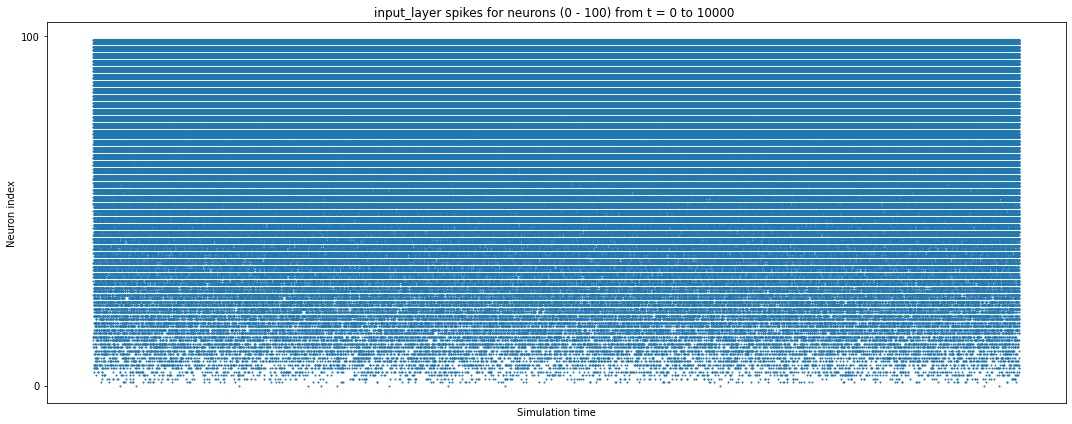

In [5]:
bindsnet.analysis.plotting.plot_spikes({"input_layer": input_spikes}, figsize=(15,6))
plt.show()

## Resulting FF curve for LIF neuron

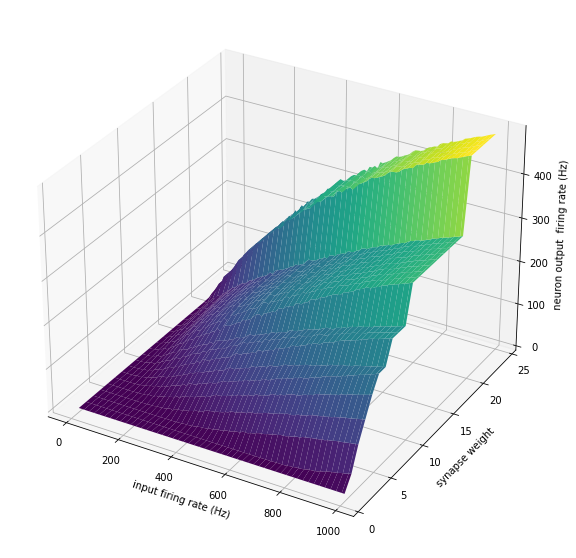

In [6]:
firing_rates = output_spikes.squeeze().sum(dim=0) / time * 1000

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(frequencies.numpy(), weights.numpy(), firing_rates.numpy(), cmap=matplotlib.cm.viridis)
ax.set_xlabel('input firing rate (Hz)')
ax.set_ylabel('synapse weight')
ax.set_zlabel('neuron output  firing rate (Hz)')
plt.show()

Looking at individual FF curves for different weights
* a weight of 20 achieves the maximum firing rate because $v_\text{thresh} - v_\text{rest} = 20$ mV
* a weight of 1 doesn't cause any firing

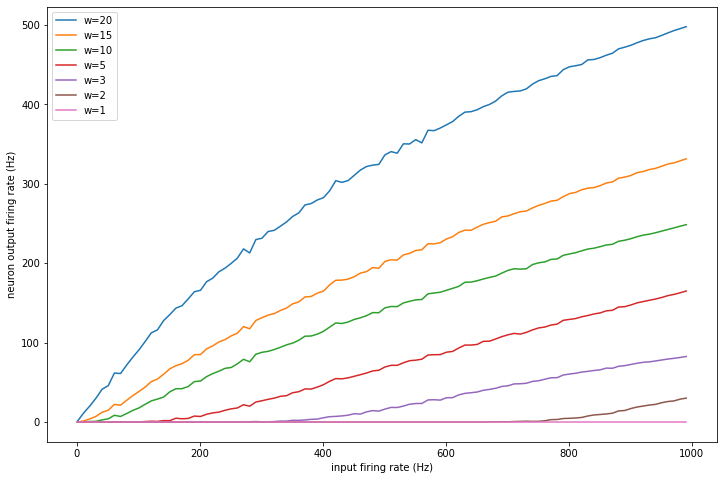

In [7]:
plot_ff_curve_weight = lambda w: plt.plot(input_frequency_range, firing_rates[:,input_weight_range == w].squeeze(), label=f'w={w}')
for w in [1,2,3,5,10,15,20][::-1]:
	plot_ff_curve_weight(w)
plt.legend()
plt.xlabel('input firing rate (Hz)')
plt.ylabel('neuron output firing rate (Hz)')
plt.show()

Checking the voltage trace for the neuron with the highest input rate, with weight 1

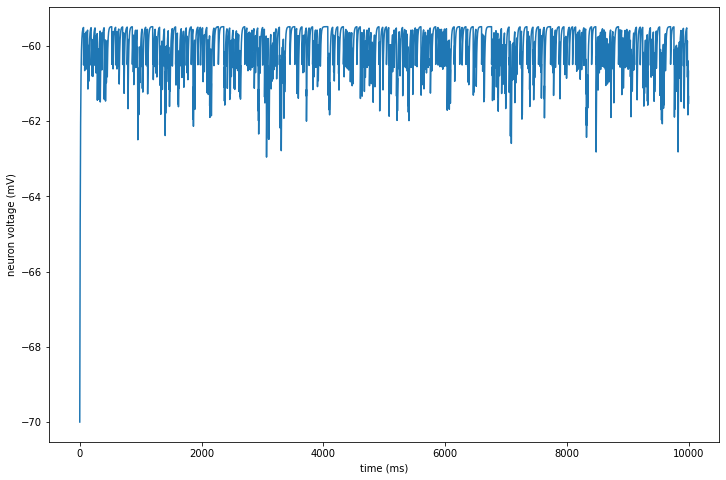

In [8]:
plt.plot(output_voltages[:,0,input_frequency_range == 951,input_weight_range == 1])
plt.xlabel('time (ms)')
plt.ylabel('neuron voltage (mV)')
plt.show()

Why is the voltage never getting above $\approx -59$ mV? The update equation for the voltage is:
$$v_{n+1} = \exp(-1/\tau)(v_n - v_\text{rest}) + v_\text{rest} + u_n$$
So we would get a fixed point if:
$$\exp(-1/\tau)(v_{fp} - v_\text{rest}) + v_\text{rest} + u = v_{fp}$$
$$\exp(-1/\tau)v_{fp} + (1 - \exp(-1/\tau))v_\text{rest} + u = v_{fp}$$
$$(1 - \exp(-1/\tau))v_\text{rest} + u = (1 - \exp(-1/\tau))v_{fp}$$
$$v_{fp} = v_\text{rest} + \frac{1}{(1 - \exp(-1/\tau))} u$$

In [9]:
-70 + 1/(1 - math.exp(-1 / 10))

-59.491668055224956

So if the maximum input magnitude is 1, the highest the neuron voltage can reach is -59.5 mV.

If the threshold voltage is -50 mV, what is the minimum input that will allow the neuron to spike?
$$u_\text{min} = (1 - \exp(-1/\tau))(v_\text{thresh} - v_\text{rest})$$

In [10]:
(1 - math.exp(-1 / 10)) * (-50 - -70)

1.9032516392808096

If we combine the firing weight with the synaptic strength, we get a total "input spike strength" - check how this relates to the output firing rate
* this corresponds to $x_\text{out} = f (\sum w x_\text{in})$ where $x$ is a firing rate (Hz)
* the main linear diagonal has a gradient of ~1 output spike/s per 25 mV/s of input. This isn't too far from the 20 mV it takes to raise a neuron from rest to threshold
  * $\therefore x(t) \approx \frac{1}{25} \sum w x(t-1)$
  * $\therefore f(u) \approx \frac{1}{25} u$

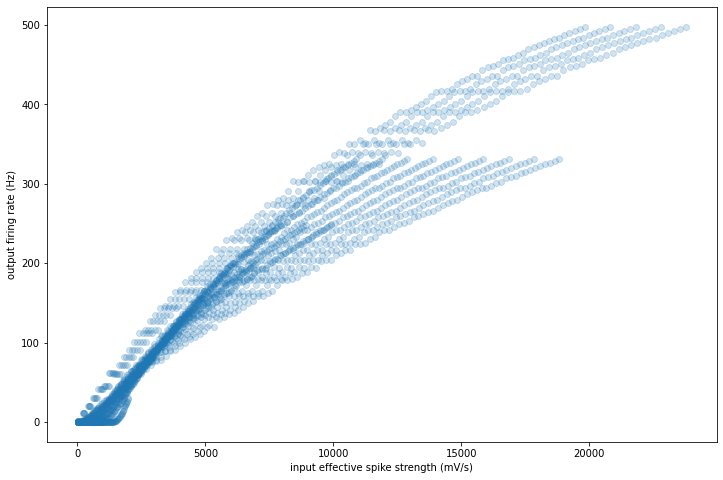

In [11]:
input_spike_strength = frequencies.flatten() * weights.flatten()
plt.scatter(input_spike_strength, firing_rates.flatten(), alpha=0.2)
plt.xlabel('input effective spike strength (mV/s)')
plt.ylabel('output firing rate (Hz)')
plt.show()